#EOF analysis of surface freshwater content & analysis of modes

# Import modules & tools

In [237]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [56]:
sb.set_style('white')
#sb.set_style("whitegrid")

In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [5]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

# Surface freshwater content data

** The definition of "surface freshwater content" **

$$
FWC = \int^{z}_{0}{\left( 1-\frac{S(z)}{S_{ref}} \right)dz}
$$

* $S_{ref}$ is 34.8 as the end-member of Atlantic water
* $S(z)$ is the salinity profile as a function of $z$
* $z$ is deptht(20), about 65m.

** Prepare the data**

In order to remove the seasonal signal of sea-ice varibility and river discharge:
* a. the linear trend is removed.
* b. the monthly mean is removed.
* *It can be proved that, a and b which goes first does not affect the EOF result.


In [6]:
FWC_name = sorted(glob.glob('../../_data/MAT files/FWC/FWC_ANHA4_*.mat'))
FWC = np.zeros([144, 800, 544])

for i in range(144):
    MAT = scipy.io.loadmat(FWC_name[i])
    FWC[i, :, :] = MAT['FWC'][:]

In [205]:
FWC[np.isnan(FWC)] = 0
FWC_a = Ats.seasonal_decomp3d(FWC)
FWC_ad = detrend(FWC_a, 0)

In [206]:
FWC_eof = np.transpose(FWC_ad[:, 350:, :], [1, 2, 0])

# EOF result

In [207]:
EOFs, PC, expvar = Ats.EOF(FWC_eof, nmode=10, ndim=3, reverse=1)

## Explained variance of each mode

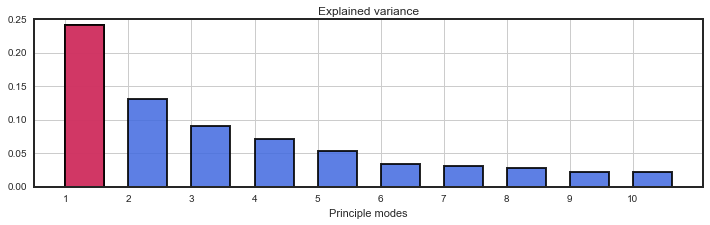

In [208]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM)
ax.set_xticks(np.arange(1, 11))
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

## Spatial pattern of each mode

In [209]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
    #proj.drawparallels(np.arange(59, 100, 10), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color=[0.8, 0.8, 0.8], lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    #proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    return CS

In [210]:
clevs = np.array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])/5.0

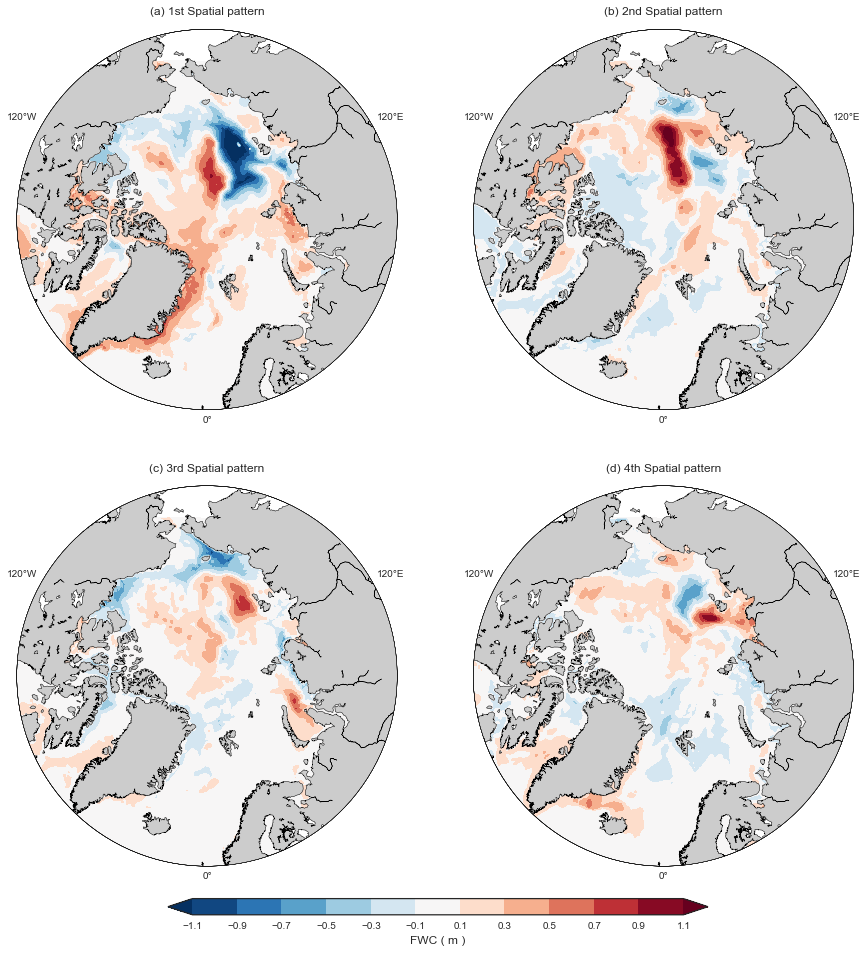

In [211]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
#colorbar
cax  = fig.add_axes([0.265, 0.08, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('FWC ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=0, direction='in')
CBar.set_ticks(clevs)

## Standardized timeseries of each mode

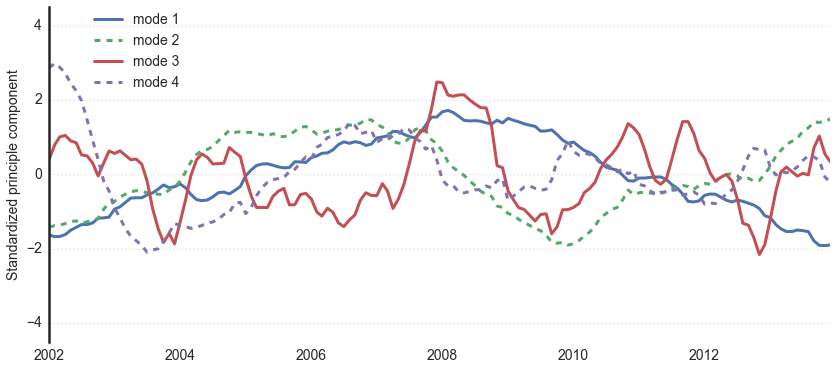

In [59]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylim([-4.5, 4.5])
ax.set_ylabel('Standardized principle component', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax = fig.gca(); ax.grid()
ax.plot(date_list, PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, PC[1, :], '--', lw=3, label='mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
ax.plot(date_list, PC[3, :], '--', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

# Try to explain the EOF result

## Other measurements

In [19]:
MAT = scipy.io.loadmat('../../_data/Mask files/velocity_driven_transport_mask.mat')
vdt_mask = MAT['mask_arctic'][:]
lon_mask = MAT['lon'][:]
lat_mask = MAT['lat'][:]

nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

mask_interp = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='nearest')
mask_range = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='linear')
mask_interp[np.isnan(mask_range)] = np.nan
mask_plot = np.ma.masked_where(np.isnan(mask_interp), mask_interp)

In [46]:
lev_dT = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])
lev_dSLP = np.array([-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])/3.0

In [218]:
def draw_vector():
    n = 4

    fig=plt.figure(figsize=(14, 14))
    ax = fig.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dFWC, lev_dT/4.0, cmap = plt.cm.RdBu_r, extend='both', alpha=0.75)
    Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], width=0.002, headwidth=3, scale=1.75, color='0.25')
    proj.contour(x, y, S_p, [33], linewidths=2.5, colors=('gray',), zorder=4)
    
    qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$', coordinates='figure', fontproperties={'weight': 'bold'})
    
    cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Freshwater content (dep < 65m)  ( m )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/4.0)
    
    ax.set_title('Composite anomaly of ocean flow (with FWC as background)', fontsize=16)

In [183]:
def draw_Ba_d18O():
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dBa, lev_dT, cmap = plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, S_p, [33], linewidths=2.5, colors=('gray',), zorder=4)
    
    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Dissolved Barium (nm)', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT)

    ax1.set_title('(a) Dissolved Ba', fontsize=14)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dd18O, lev_dT/5.0, cmap = plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, S_p, [33], linewidths=2.5, colors=('gray',), zorder=4)
    
    cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('d18O', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/5.0)

    ax2.set_title('(b) d18O', fontsize=14)

### Ocean velocity

In [20]:
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vozocrtx1 = MAT['vozocrtx1'][:]
vomecrty0 = MAT['vomecrty0'][:]
vomecrty1 = MAT['vomecrty1'][:]

### Transpolar drift intensity (by my definition)

In [21]:
u_tpd = vozocrtx0[:, mask_interp==2]
v_tpd = vomecrty0[:, mask_interp==2]
vdt = np.abs(np.nanmean(np.sqrt(u_tpd*u_tpd+v_tpd*v_tpd), 1))

### Beaufort Gyre intensity (by sea level height)

In [42]:
H_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc'
h_obj = nc.Dataset(H_FName)
SSH = h_obj.variables['sossheig'][:, :, :]
SSH_BG = np.nanmax(SSH[:, mask_interp==1], 1) + 0.4

### Sea surface salinity

In [89]:
S_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
s_obj = nc.Dataset(S_FName)
S = s_obj.variables['isssalin'][:, :, :]

### (X) AO index 

In [76]:
MAT = scipy.io.loadmat('../../_data/Exchange/AO_inds.mat')
AO = MAT['AO_index'][0, :]

### Dissolved Ba & d18O 

In [225]:
FName1 = '/ocean/yingkai/GEOTRACES/Simulations/BASE01_1m_20020101_20131231_ptrc_T.nc'
FName2 = '/ocean/yingkai/GEOTRACES/Simulations/BASE03_1m_20020101_20131231_ptrc_T.nc'
ptrc_obj1 = nc.Dataset(FName1)
ptrc_obj2 = nc.Dataset(FName2)
Ba = ptrc_obj1.variables['Ba'][:, :20, :, :]
d18O = ptrc_obj2.variables['d18O'][:, :20, :, :]
Ba[Ba==0]=np.nan
d18O[Ba==0]=np.nan
Ba = np.nanmean(Ba, 1)
d18O = np.nanmean(d18O, 1)

## Assumptions

* EOF(FWC) has been done with "dtrend" and "anomaly" data, so no information about sea-ice varibility/trend & seasonality of river input.
* No EU runoff in CAA;
* Assume that convection is not important;
* NA, EU Runoff: high Ba, low d18O, high FWC;
* Some CAA Runoff: low Ba, low d18O, high FWC;
* Atlantic inflow: low Ba, high d18O, low FWC (high Salin.);
* Pacific inflow: low Ba, low d18O (comparing with Atlantic), high FWC.

## First mode

### Relation with the intensity of transpolar drift & BG

In [23]:
pearsonr(PC[0, :], vdt)

(0.66550203718142587, 9.1161257090469969e-20)

In [82]:
pearsonr(PC[0, :], SSH_BG)

(0.26666546363377253, 0.0012344189501324141)

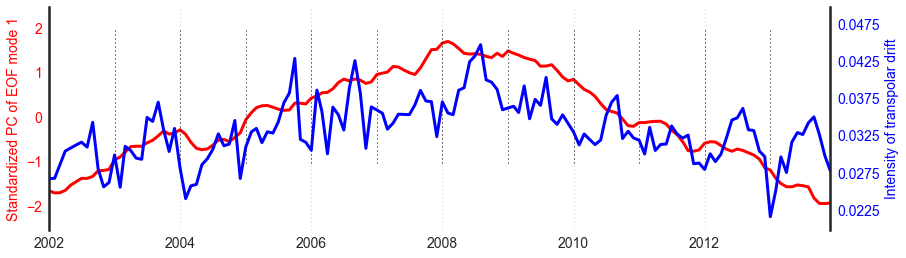

In [197]:
fig = plt.figure(figsize=(14, 4))
ax = fig.gca(); ax.grid()
ax2 = ax.twinx()

ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.set_ylim([-2.5, 2.5])
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 1', fontsize=14, color='r')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")
for tl in ax.get_yticklabels():
    tl.set_color('r')

ax2.set_ylim([0.02, 0.05])
ax2.set_yticks(np.arange(0.0225, 0.0525, 0.005))
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_ylabel('Intensity of transpolar drift', fontsize=14, color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax.plot(date_list, PC[0, :], 'r', lw=3, label='PC of the EOF 1st mode')
for i in range(12, 144, 12):
    ax.axvline(date_list[i], ymin=0.3, ymax=0.9, color='k', lw=1, ls=':')
ax2.plot(date_list, vdt, 'b', lw=3, label='Intensity of transpolar drift')


### Composite anomaly of uv, Ba and d18O by timeseries

In [226]:
thres = 1
u_pc0_p = np.nanmean(vozocrtx0[PC[0, :]>thres, :, :], 0)
v_pc0_p = np.nanmean(vomecrty0[PC[0, :]>thres, :, :], 0)
Ba_pc0_p = np.nanmean(Ba[PC[0, :]>thres, :, :], 0)
d18O_pc0_p = np.nanmean(d18O[PC[0, :]>thres, :, :], 0)
FWC_pc0_p = np.nanmean(FWC[PC[0, :]>thres, :, :], 0) 
#SLP_pc0_p = np.nanmean(slp[PC[0, :]>thres, :, :], 0) 
S_p = np.nanmean(S[PC[0, :]>thres, :, :], 0) 

u_pc0_n = np.nanmean(vozocrtx0[PC[0, :]<-thres, :, :], 0)
v_pc0_n = np.nanmean(vomecrty0[PC[0, :]<-thres, :, :], 0)
Ba_pc0_n = np.nanmean(Ba[PC[0, :]<-thres, :, :], 0)
d18O_pc0_n = np.nanmean(d18O[PC[0, :]<-thres, :, :], 0)
FWC_pc0_n = np.nanmean(FWC[PC[0, :]<-thres, :, :], 0)
#SLP_pc0_n = np.nanmean(slp[PC[0, :]<-thres, :, :], 0) 

u = u_pc0_p - u_pc0_n
v = v_pc0_p - v_pc0_n
dFWC = FWC_pc0_p - FWC_pc0_n
dBa = Ba_pc0_p - Ba_pc0_n
dd18O = d18O_pc0_p - d18O_pc0_n
#dSLP = (SLP_pc0_p - SLP_pc0_n)/100.0

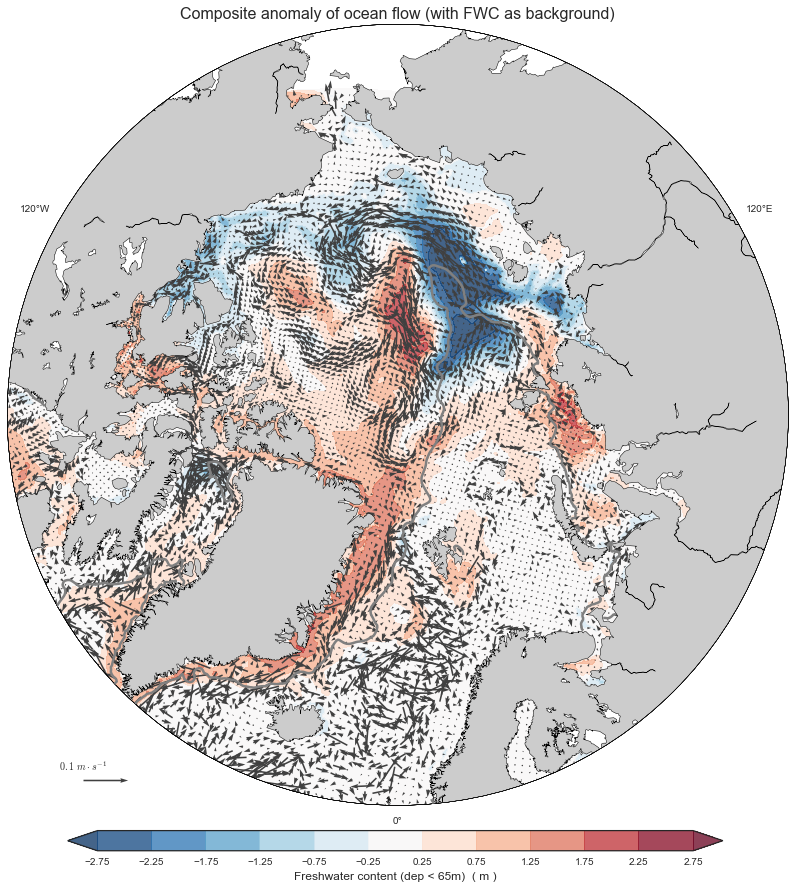

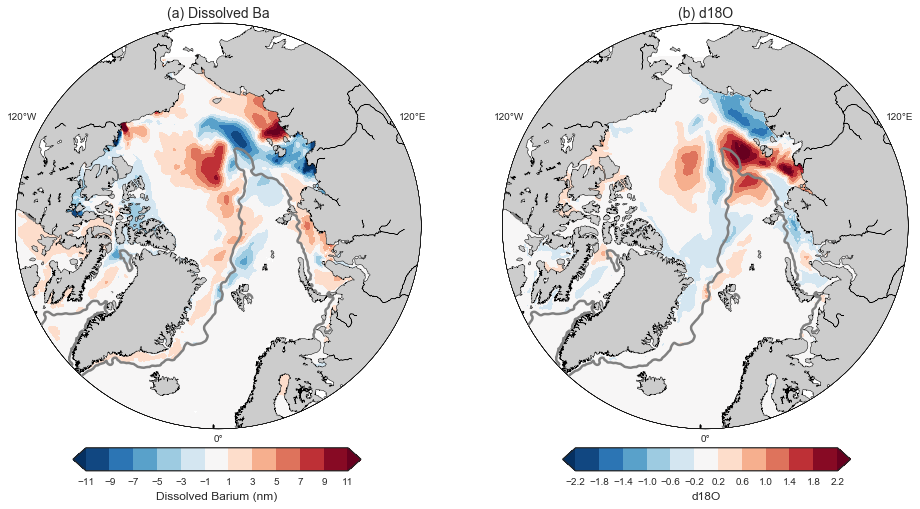

In [227]:
draw_vector()
draw_Ba_d18O()

** According to u/v & correlation: **
* Stronger transpolar drift
* Stronger Beaufort Gyre
* Stronger flow from Makarov Basin & Laptev Sea to Beaufort Gyre 
* Weak CAA-Labrador Sea transport
* Less Bering Strait inflow

** Based on tracer modelling & FWC: **
* More Atlantic water in Makarov Basin and Laptev Sea.
* More runoff water in the transpolar drift.
* Some of the Atlantic water involved in the Beaufort Gyre.
* More runoff is transported from Kara Sea to Laptev Sea
* *Less NA runoff in CAA but the loss is balanced by CAA runoff.*
* *Less Bering Strait inflow, but more Laptev Sea runoff in East Siberian Sea.*
* *Less Pacific inflow in Beaufort Gyre*

** Don't know:**
* Low FWC but high Ba at the eustary of Mackenzie.

## Second mode

In [152]:
pearsonr(PC[1, :], vdt)

(0.066066609450942559, 0.4314283460512236)

In [153]:
pearsonr(PC[1, :], SSH_BG)

(-0.24046429029915839, 0.0036943527683480589)

In [229]:
thres = 1
u_pc1_p = np.nanmean(vozocrtx0[PC[1, :]>thres, :, :], 0)
v_pc1_p = np.nanmean(vomecrty0[PC[1, :]>thres, :, :], 0)
Ba_pc1_p = np.nanmean(Ba[PC[1, :]>thres, :, :], 0)
d18O_pc1_p = np.nanmean(d18O[PC[1, :]>thres, :, :], 0)
FWC_pc1_p = np.nanmean(FWC[PC[1, :]>thres, :, :], 0) 
#SLP_pc1_p = np.nanmean(slp[PC[1, :]>thres, :, :], 0) 
S_p = np.nanmean(S[PC[1, :]>thres, :, :], 0) 

u_pc1_n = np.nanmean(vozocrtx0[PC[1, :]<-thres, :, :], 0)
v_pc1_n = np.nanmean(vomecrty0[PC[1, :]<-thres, :, :], 0)
Ba_pc1_n = np.nanmean(Ba[PC[1, :]<-thres, :, :], 0)
d18O_pc1_n = np.nanmean(d18O[PC[1, :]<-thres, :, :], 0)
FWC_pc1_n = np.nanmean(FWC[PC[1, :]<-thres, :, :], 0)
#SLP_pc1_n = np.nanmean(slp[PC[1, :]<-thres, :, :], 0) 



u = u_pc1_p - u_pc1_n
v = v_pc1_p - v_pc1_n
dFWC = FWC_pc1_p - FWC_pc1_n
dBa = Ba_pc1_p - Ba_pc1_n
dd18O = d18O_pc1_p - d18O_pc1_n
#dSLP = (SLP_pc1_p - SLP_pc1_n)/100.0

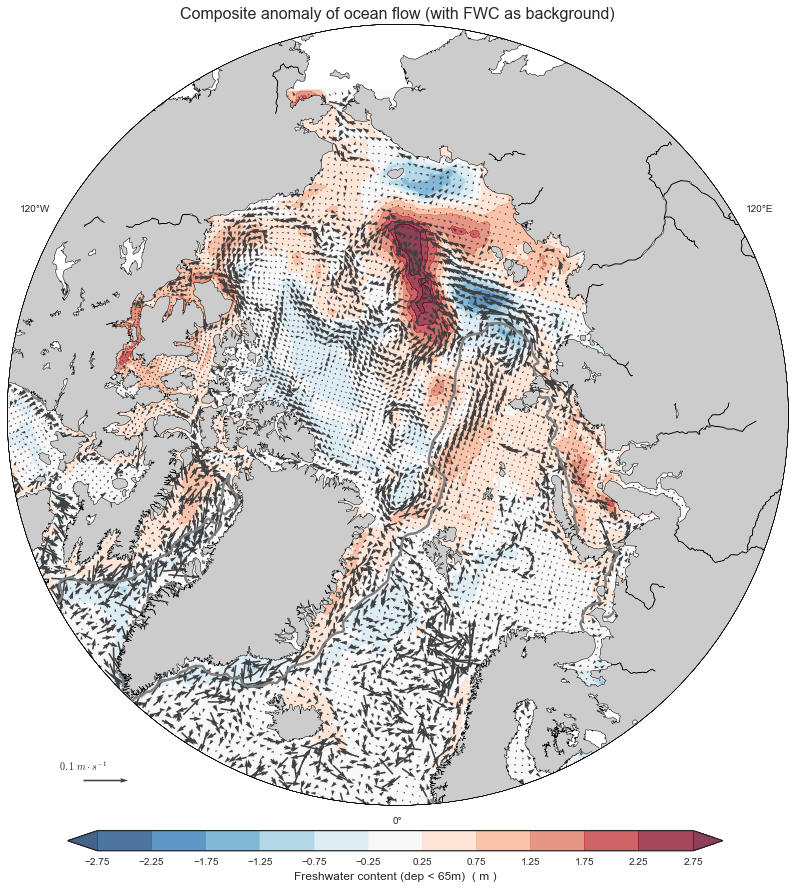

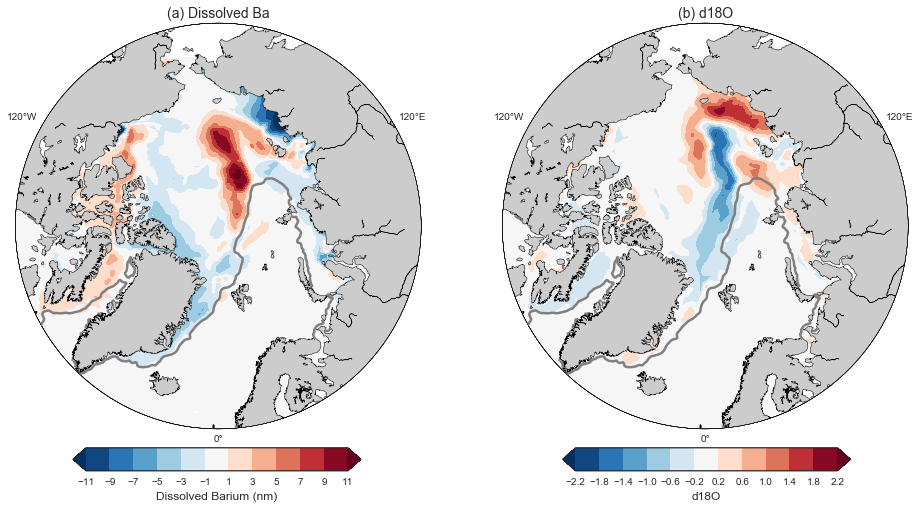

In [230]:
draw_vector()
draw_Ba_d18O()

** According to u/v & correlation: **
* Weak Beaufort Gyre.
* Strong "Beaufort Sea -> Lancast Sound -> Baffin Bay" transport 
* For transpolar drift (TPD): 
    * In general, no correlation between PC and TPD inrensity.
    * But the eastern side of TPD gets stronger.
    * *Could be a shitf of Beaufort Gyre.*


** Based on tracer modelling & FWC: **
* More NA runoff in the southern part of CAA.
* Less NA runoff in Beaufort Gyre, Fram Strait.
* More EU runoff in the eastern side of TPD, less in East Siberian Sea
* A bit more Atlantic water (or less EU runoff) along the coast of Kara Sea and Laptev Sea.

## Third Mode

In [220]:
pearsonr(PC[2, :], vdt)

(0.053640055738515012, 0.52312830797586751)

In [157]:
pearsonr(PC[2, :], SSH_BG[:])

(0.56431287570252975, 1.7605960940677861e-13)

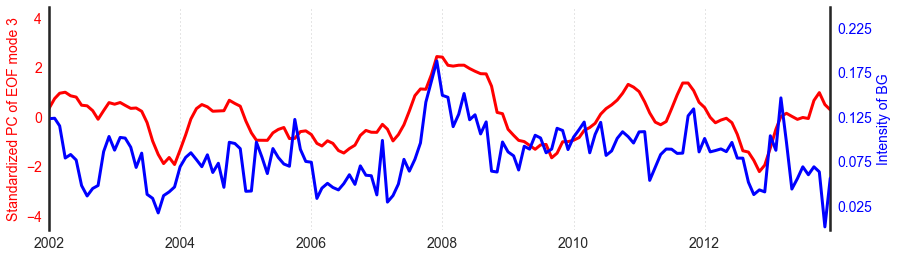

In [158]:
fig = plt.figure(figsize=(14, 4))
ax = fig.gca(); ax.grid()
ax2 = ax.twinx()

ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.set_ylim([-4.5, 4.5])
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 3', fontsize=14, color='r')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")
for tl in ax.get_yticklabels():
    tl.set_color('r')

ax2.set_ylim([0, 0.25])
ax2.set_yticks(np.arange(0.025, 0.275, 0.05))
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_ylabel('Intensity of BG', fontsize=14, color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
ax.plot(date_list, PC[2, :], 'r', lw=3, label='PC of the EOF 3rd mode')
ax2.plot(date_list, SSH_BG, 'b', lw=3, label='Intensity of transpolar drift')

In [231]:
thres = 1
u_pc2_p = np.nanmean(vozocrtx0[PC[2, :]>thres, :, :], 0)
v_pc2_p = np.nanmean(vomecrty0[PC[2, :]>thres, :, :], 0)
Ba_pc2_p = np.nanmean(Ba[PC[2, :]>thres, :, :], 0)
d18O_pc2_p = np.nanmean(d18O[PC[2, :]>thres, :, :], 0)
FWC_pc2_p = np.nanmean(FWC[PC[2, :]>thres, :, :], 0) 
#SLP_pc2_p = np.nanmean(slp[PC[2, :]>thres, :, :], 0) 
S_p = np.nanmean(S[PC[2, :]>thres, :, :], 0) 

u_pc2_n = np.nanmean(vozocrtx0[PC[2, :]<-thres, :, :], 0)
v_pc2_n = np.nanmean(vomecrty0[PC[2, :]<-thres, :, :], 0)
Ba_pc2_n = np.nanmean(Ba[PC[2, :]<-thres, :, :], 0)
d18O_pc2_n = np.nanmean(d18O[PC[2, :]<-thres, :, :], 0)
FWC_pc2_n = np.nanmean(FWC[PC[2, :]<-thres, :, :], 0)
#SLP_pc2_n = np.nanmean(slp[PC[2, :]<-thres, :, :], 0) 

u = u_pc2_p - u_pc2_n
v = v_pc2_p - v_pc2_n
dFWC = FWC_pc2_p - FWC_pc2_n
dBa = Ba_pc2_p - Ba_pc2_n

dd18O = d18O_pc2_p - d18O_pc2_n
#dSLP = (SLP_pc2_p - SLP_pc2_n)/100.0

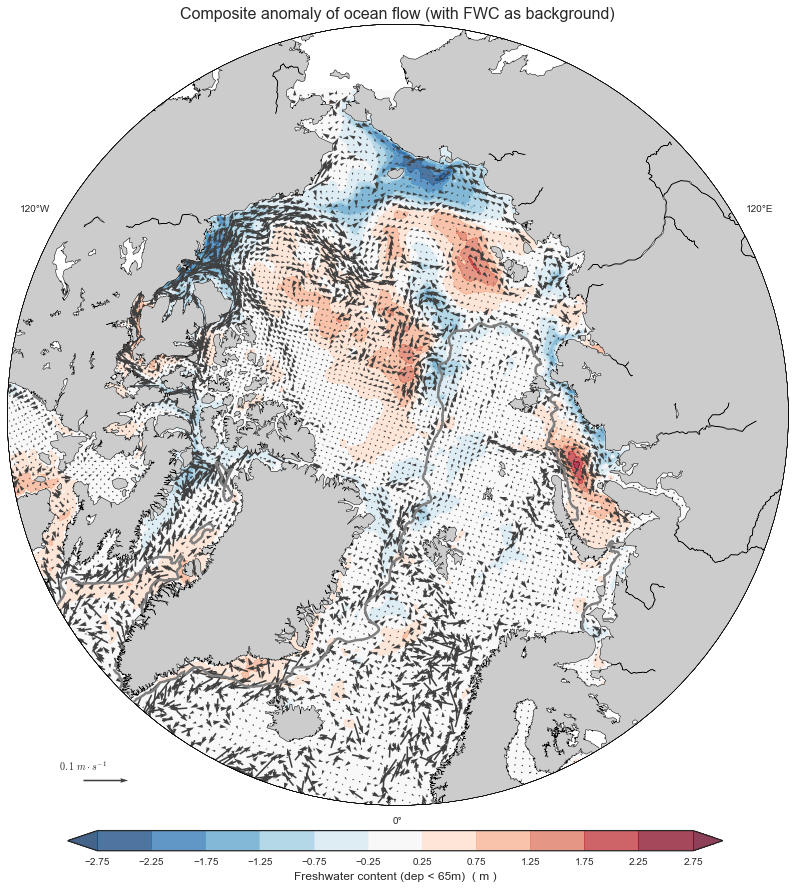

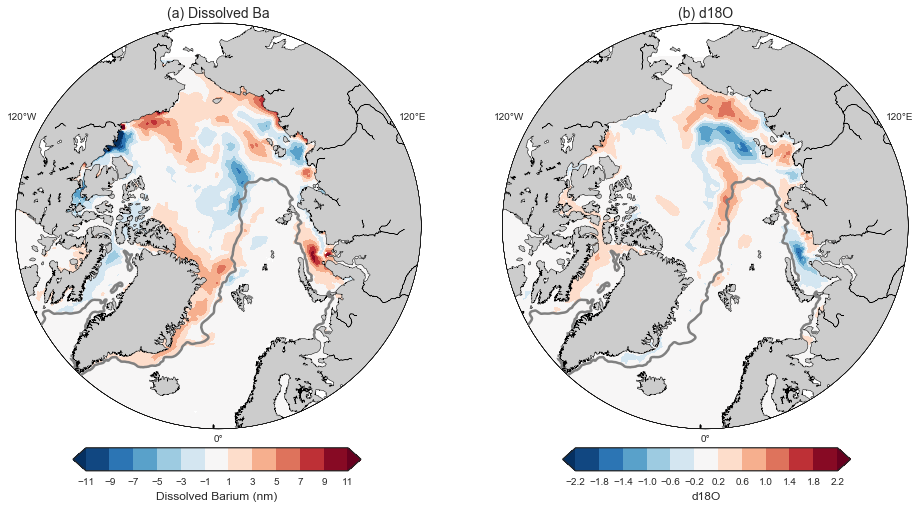

In [232]:
draw_vector()
draw_Ba_d18O()

** According to u/v & correlation: **
* Strong & Larger Beaufort Gyre.
* Weak CAA-Labrador Sea transport (like 1st mode)
* Mean or weak transpolar drift (not like 1st mode)
* Looks like "2008 case". 

** Based on tracer modelling & FWC: **
* Less NA runoff in CAA, but maybe more Atlantic inflow (by a stronger West Greenland current).
* More NA runoff in the Beaufort Gyre.
* Runoff is accumulating at Kara Sea.
* More EU runoff at Makarov Basin and less in TPD.

**Don't know: **
* Low FWC but high d18O, high Ba at East Siberian Sea (*more EU runoff replaced by less NA runoff*) 


## Fourth mode

In [236]:
pearsonr(PC[3, :], vdt)

(0.09832455657723875, 0.241014513022731)

In [235]:
pearsonr(PC[3, :], SSH_BG[:])

(0.02469270394369482, 0.76893002246863495)

In [233]:
thres = 1
u_pc3_p = np.nanmean(vozocrtx0[PC[3, :]>thres, :, :], 0)
v_pc3_p = np.nanmean(vomecrty0[PC[3, :]>thres, :, :], 0)
Ba_pc3_p = np.nanmean(Ba[PC[3, :]>thres, :, :], 0) 
FWC_pc3_p = np.nanmean(FWC[PC[3, :]>thres, :, :], 0) 
#SLP_pc3_p = np.nanmean(slp[PC[3, :]>thres, :, :], 0)
d18O_pc3_p = np.nanmean(d18O[PC[3, :]>thres, :, :], 0)
S_p = np.nanmean(S[PC[3, :]>thres, :, :], 0) 

u_pc3_n = np.nanmean(vozocrtx0[PC[3, :]<-thres, :, :], 0)
v_pc3_n = np.nanmean(vomecrty0[PC[3, :]<-thres, :, :], 0)
Ba_pc3_n = np.nanmean(Ba[PC[3, :]<-thres, :, :], 0)
d18O_pc3_n = np.nanmean(d18O[PC[3, :]<-thres, :, :], 0)
FWC_pc3_n = np.nanmean(FWC[PC[3, :]<-thres, :, :], 0)
#SLP_pc3_n = np.nanmean(slp[PC[3, :]<-thres, :, :], 0) 

u = u_pc3_p - u_pc3_n
v = v_pc3_p - v_pc3_n
dFWC = FWC_pc3_p - FWC_pc3_n
dBa = Ba_pc3_p - Ba_pc3_n
dd18O = d18O_pc3_p - d18O_pc3_n 
#dSLP = (SLP_pc3_p - SLP_pc3_n)/100.0

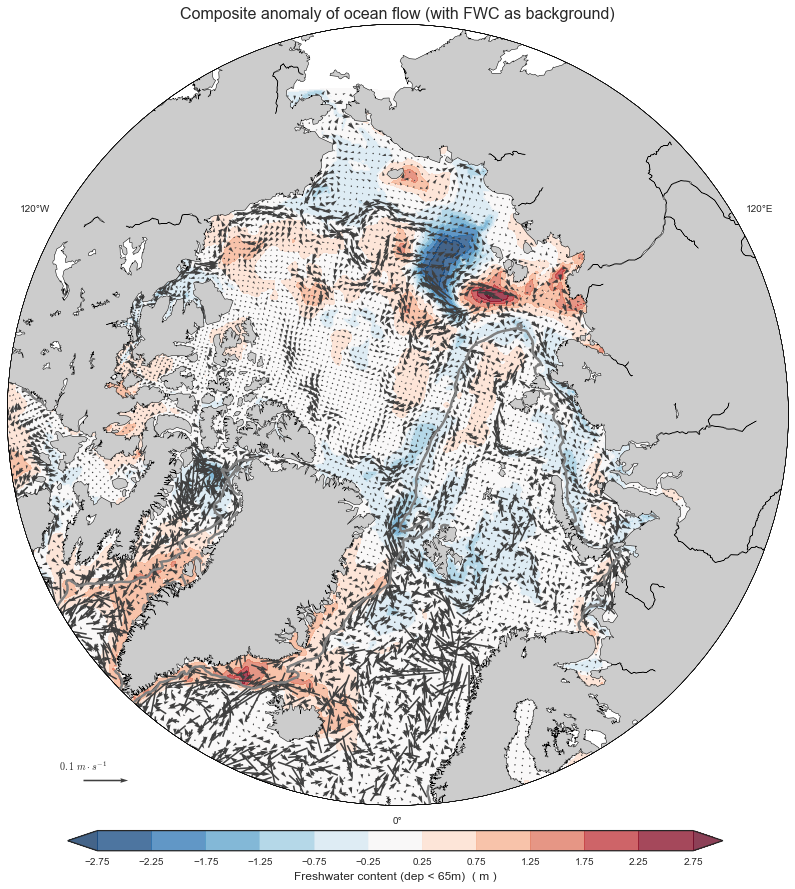

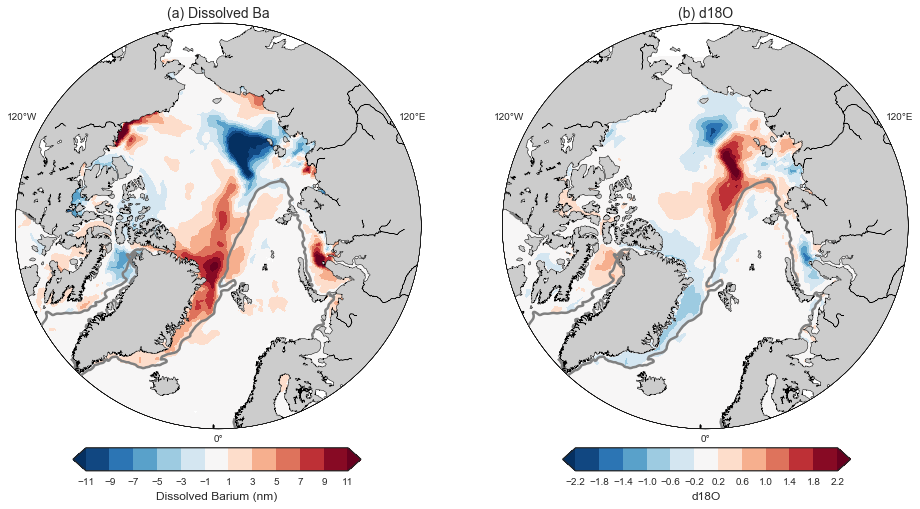

In [234]:
draw_vector()
draw_Ba_d18O()

** According to u/v & correlation: **
* Very hard to summarize.

** Based on tracer modelling & FWC: **
* EU runoff accumulating at Kara Sea.
* More NA runoff at Fram Strait.

**Don't know: **
* The negative Ba anomaly in Makarov Basin


# Conclusion

* Tracer modelling result in general consistant with frshwater content which is calculated based on ANHA4 salinity.
* Ba values in Baffin Bay and Fram Strait can characterize the NA runoff transport.
    * Strong BG --> more NA runoff goes to Fram Strait.
* The loss of Ba/runoff/frshwater in Markarov Basin is balanced by the gain in TPD.

# Next

* Try to add more meanings to the EOF of FWC.
* Combine the analysis with export at transects.
* The atmospheric conterpart (not only just SLP, will combine reanalysis data)
* Passive tracer in Laptev Sea and Beaufort Sea